In [1]:
import os
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr
import dask
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import pandas as pd
import datetime
import copy

In [2]:
iclassdir = '/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/'
statsdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/stats/'
terrain_file = f'{iclassdir}corgridded_terrain.c0/topo_cacti_csapr2_large.nc'
stats_file = f'{statsdir}/stats_tracknumbersv1.0_20181015.0000_20190303.0000.nc'
# stats_file3d = f'{statsdir}/stats/stats_3d_ppi_20181015.0000_20190303.0000.nc'
sat_file = f'{statsdir}/stats_goes16_20181015.0000_20190303.0000.nc'
sonde_file = f'{statsdir}/interpsonde_parameters_celltrack_20181015.0000_20190303.0000.nc'

radar_lat = -32.1264
radar_lon = -64.7284

figdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/figures/celltrack_environment_stats_jim/'
figdir_jointhist = f'{figdir}jointhist/'
os.makedirs(figdir, exist_ok=True)
os.makedirs(figdir_jointhist, exist_ok=True)

In [22]:
xr.set_options(display_style='text')

In [4]:
# Read sonde data
sonde = xr.open_dataset(sonde_file)
sonde.dims['tracks']

6895

In [5]:
# Read 2D track data
stats2d = xr.open_dataset(stats_file)
time_res = stats2d.attrs['time_resolution_hour']
pixel_radius = stats2d.attrs['pixel_radius_km']
stats2d.dims['tracks']

6895

In [6]:
# Read satellite data
sat = xr.open_dataset(sat_file, drop_variables=['basetime', 'cell_area'])
sat.dims['tracks']

6895

In [7]:
# Combine datasets by coordinates
stats = xr.combine_by_coords([stats2d, sat, sonde], combine_attrs='override')
stats.load()
print(stats)

<xarray.Dataset>
Dimensions:                      (reltime: 4, times: 60, tracks: 6895)
Coordinates:
  * tracks                       (tracks) int32 0 1 2 3 ... 6891 6892 6893 6894
  * reltime                      (reltime) int32 0 -1 -2 -3
  * times                        (times) int32 0 1 2 3 4 5 ... 54 55 56 57 58 59
Data variables: (12/285)
    time                         (tracks, reltime) datetime64[ns] 2018-10-16T...
    tallenough_sfc               (tracks, reltime) float32 1.0 1.0 ... 1.0 1.0
    CAPE_sfc                     (tracks, reltime) float32 nan nan ... nan nan
    CIN_NA_sfc                   (tracks, reltime) float32 nan nan ... nan nan
    CIN_NA_fract_sfc             (tracks, reltime) float32 nan nan ... nan nan
    CIN_IB_sfc                   (tracks, reltime) float32 -9.999e+03 ... -9....
    ...                           ...
    end_merge_timeindex          (tracks) float64 nan nan nan ... 1.0 nan nan
    end_merge_cloudnumber        (tracks) float64 nan nan n

In [8]:
tracks = stats['tracks']
times = stats['times']

lifetime = stats['lifetime'] * time_res
start_time = stats['start_basetime']
end_time = stats['end_basetime']
end_merge_tracknumber = stats['end_merge_tracknumber']
start_split_tracknumber = stats['start_split_tracknumber']
cell_lon = stats['cell_meanlon']
cell_lat = stats['cell_meanlat']
cell_area = stats['cell_area']
maxrange_flag = stats['maxrange_flag']

maxdbz = stats['maxdbz']
eth10 = stats['maxETH_10dbz']
eth20 = stats['maxETH_20dbz']
eth30 = stats['maxETH_30dbz']
eth40 = stats['maxETH_40dbz']
eth50 = stats['maxETH_50dbz']

ctt = stats['cloud_top_temperature_min']
cth = stats['cloud_top_height_max']

In [9]:
stats.sizes

Frozen(SortedKeysDict({'tracks': 6895, 'reltime': 4, 'times': 60}))

In [11]:
tracks = stats['tracks']
times = stats['times']
# height = stats['z'] / 1000.
# time_res = stats.attrs['time_resolution_hour']
# pixel_radius = stats.attrs['pixel_radius_km']
print(f'Number of total tracks: {len(tracks)}')

# Get cell initial location
cell_lon0 = stats['cell_meanlon'].isel(times=0)
# Remove NaN
ind = np.where(~np.isnan(cell_lon0))[0]
ntracks = len(ind)
print(f'Number of valid tracks: {ntracks}')

# Subset tracks for the entire dataset
stats = stats.isel(tracks=ind)
stats.dims['tracks']

Number of total tracks: 6895
Number of valid tracks: 6887


6887

In [12]:
lifetime = stats['lifetime'] * time_res
start_time = stats['start_basetime']
end_time = stats['end_basetime']
end_merge_tracknumber = stats['end_merge_tracknumber']
start_split_tracknumber = stats['start_split_tracknumber']
cell_lon = stats['cell_meanlon']
cell_lat = stats['cell_meanlat']
cell_area = stats['cell_area']
maxrange_flag = stats['maxrange_flag']

In [19]:
# Choose 0 hour relative time, and filter negative parcel values
cape = stats['CAPE_mu'].where(stats['CAPE_mu'] > 0).sel(reltime=0)
cin = stats['CIN_IB_mu'].where(stats['CIN_IB_mu'] >= 0).sel(reltime=0)
lcl_z = stats['LCL_height_mu'].where(stats['LCL_height_mu'] >= 0).sel(reltime=0) / 1000
lfc_z = stats['LFC_height_mu'].where(stats['LFC_height_mu'] >= 0).sel(reltime=0) / 1000
lnb_z = stats['EL_height_mu'].where(stats['EL_height_mu'] >= 0).sel(reltime=0) / 1000
lpl_z = stats['initial_ht_parcel_mu'].where(stats['initial_ht_parcel_mu'] >= 0).sel(reltime=0) / 1000
q850p = stats['rvap_850mb'].sel(reltime=0)
q700p = stats['rvap_700mb'].sel(reltime=0)
rh700p = stats['rh_700mb'].sel(reltime=0)
rh500p = stats['rh_500mb'].sel(reltime=0)
shear6mag = stats['shear_mag_bulk_0to6km'].sel(reltime=0)
shear3mag = stats['shear_mag_bulk_0to3km'].sel(reltime=0)
u700p = stats['U_700mb'].sel(reltime=0)
v700p = stats['V_700mb'].sel(reltime=0)
u850p = stats['U_850mb'].sel(reltime=0)
v850p = stats['V_850mb'].sel(reltime=0)

In [13]:
# Get track start values
start_maxrange_flag = maxrange_flag.isel(times=0)
start_lon = cell_lon.isel(times=0)
start_lat = cell_lat.isel(times=0)

# Get track start/end hour
start_hour = start_time.dt.hour
end_hour = end_time.dt.hour

In [15]:
# Find tracks not end with merge or not start with split
nonmerge = np.where(np.isnan(end_merge_tracknumber))[0]
nonsplit = np.where(np.isnan(start_split_tracknumber))[0]
ntracks_nonmerge = len(nonmerge)
ntracks_nonsplit = len(nonsplit)
print(f'Number of non-merge tracks: {ntracks_nonmerge}')
print(f'Number of non-split tracks: {ntracks_nonsplit}')

# nonsplit_in = np.where(np.isnan(start_split_tracknumber) & (start_maxrange_flag == 1))[0]
# nonmerge_in = np.where(np.isnan(end_merge_tracknumber) & (end_maxrange_flag == 1))[0]
# ntracks_nonsplit_in = len(nonsplit_in)
# ntracks_nonmerge_in = len(nonmerge_in)
# print(f'Number of non-split tracks within max range: {ntracks_nonsplit_in}')
# print(f'Number of non-merge tracks within max range: {ntracks_nonmerge_in}')

merge = np.where(end_merge_tracknumber > 0)[0]
split = np.where(start_split_tracknumber > 0)[0]
ntracks_merge = len(merge)
ntracks_split = len(split)
print(f'Number of merge tracks: {ntracks_merge}')
print(f'Number of split tracks: {ntracks_split}')

Number of non-merge tracks: 5284
Number of non-split tracks: 5359
Number of merge tracks: 1603
Number of split tracks: 1528


In [18]:
lon_SDC = -65

# Find times for cells that initiate east of SDC at 08 LT (11 UTC)
start_time_eSDC_LT8 = start_time.where((start_hour == 11) & (start_lon > lon_SDC), drop=True)
dates_eSDC_LT8 = start_time_eSDC_LT8.dt.strftime('%b-%d')
unique_dates_eSDC_LT8, ncells_eSDC_LT8 = np.unique(dates_eSDC_LT8, return_counts=True)
print(unique_dates_eSDC_LT8)
print(ncells_eSDC_LT8)
unique_dates_eSDC_LT8[ncells_eSDC_LT8 > 10]

['Dec-01' 'Dec-02' 'Dec-05' 'Dec-09' 'Dec-15' 'Dec-18' 'Feb-25' 'Nov-06'
 'Nov-07' 'Nov-11' 'Nov-12' 'Nov-17' 'Nov-22' 'Nov-26' 'Nov-27' 'Oct-17'
 'Oct-18' 'Oct-19' 'Oct-21' 'Oct-22' 'Oct-23' 'Oct-25' 'Oct-26' 'Oct-29'
 'Oct-31']
[ 2 16  3  6  2 11 11 18  3 23 15  2  3  6 23  5  7  1  3 15  6  8 11 13
  3]


array(['Dec-02', 'Dec-18', 'Feb-25', 'Nov-06', 'Nov-11', 'Nov-12',
       'Nov-27', 'Oct-22', 'Oct-26', 'Oct-29'], dtype=object)

In [20]:
cape.shape, start_hour.shape, start_lon.shape

((6887,), (6887,), (6887,))

(array([66., 21., 22., 15.,  1., 21., 10., 26.,  7.,  4.,  0.,  0.,  0.,
         0., 18.,  5.,  0.]),
 array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
        1100, 1200, 1300, 1400, 1500, 1600, 1700]),
 <BarContainer object of 17 artists>)

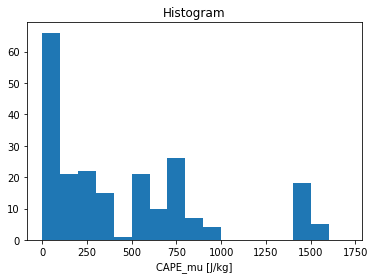

In [38]:
bins_cape = np.arange(0, 1800, 100)
cape.where((start_hour == 11) & (start_lon > lon_SDC), drop=True).plot.hist(bins=bins_cape)

(array([ 7.,  6., 19., 23.,  5., 11., 23.,  8., 49.,  1.,  5., 18.,  0.,
        38.]),
 array([ 5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ,
        10.5, 11. , 11.5, 12. ]),
 <BarContainer object of 14 artists>)

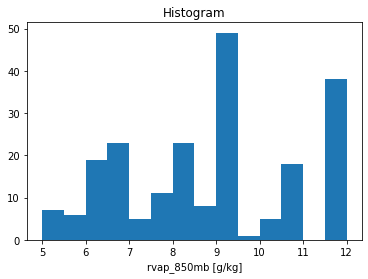

In [39]:
bins_q850p = np.arange(5,12.1,0.5)
q850p.where((start_hour == 11) & (start_lon > lon_SDC), drop=True).plot.hist(bins=bins_q850p)

(array([65.,  0.,  6., 23., 59., 28., 32.,  3.,  0.,  0.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

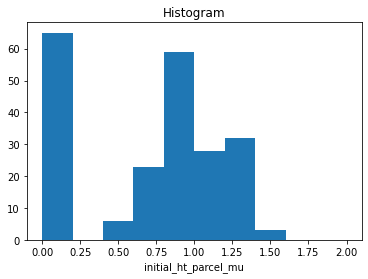

In [42]:
bins_lpl = np.arange(0, 2.01, 0.2)
lpl_z.where((start_hour == 11) & (start_lon > lon_SDC), drop=True).plot.hist(bins=bins_lpl)

(array([18.,  0., 23.,  1.,  6.,  7., 17., 26., 36., 44., 15., 23.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <BarContainer object of 12 artists>)

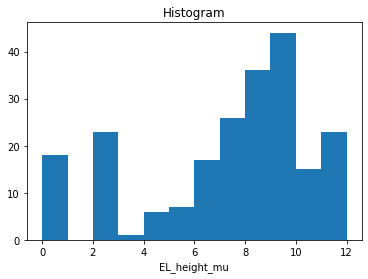

In [33]:
bins_lnb = np.arange(0, 13, 1)
lnb_z.where((start_hour == 11) & (start_lon > lon_SDC), drop=True).plot.hist(bins=bins_lnb)

(array([27., 50., 21., 19.,  3., 18., 19., 31., 28.]),
 array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90]),
 <BarContainer object of 9 artists>)

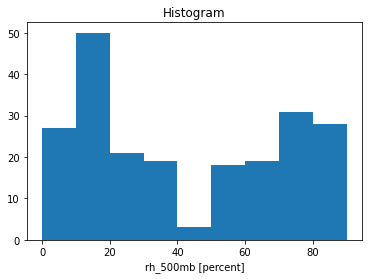

In [43]:
bins_rh500p = np.arange(0, 91, 10)
rh500p.where((start_hour == 11) & (start_lon > lon_SDC), drop=True).plot.hist(bins=bins_rh500p)

(array([ 3.,  0., 37., 20., 40., 34., 50., 17.,  0., 15.]),
 array([10., 13., 16., 19., 22., 25., 28., 31., 34., 37., 40.]),
 <BarContainer object of 10 artists>)

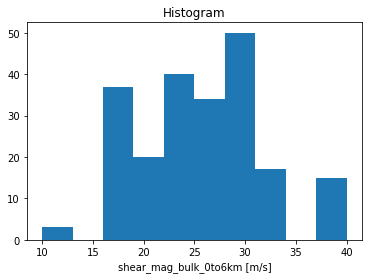

In [47]:
bins_shear6mag = np.arange(10, 40.1, 3)
shear6mag.where((start_hour == 11) & (start_lon > lon_SDC), drop=True).plot.hist(bins=bins_shear6mag)

In [70]:
idx = np.where((start_hour == 11) & (start_lon > lon_SDC))[0]
hist_cape, bins = np.histogram(cape.sel(tracks=idx), bins=bins_cape)
hist_q850p, bins = np.histogram(q850p.sel(tracks=idx), bins=bins_q850p)
hist_lpl, bins = np.histogram(lpl_z.sel(tracks=idx), bins=bins_lpl)
hist_lnb, bins = np.histogram(lnb_z.sel(tracks=idx), bins=bins_lnb)
hist_rh500p, bins = np.histogram(rh500p.sel(tracks=idx), bins=bins_rh500p)
hist_shear6mag, bins = np.histogram(shear6mag.sel(tracks=idx), bins=bins_shear6mag)

<BarContainer object of 17 artists>

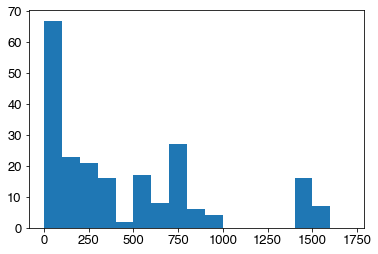

In [71]:
binv_cape = bins_cape[:-1] + np.diff(bins_cape)/2
plt.bar(binv_cape, hist_cape, width=100)
# hist_q850p, bins = np.histogram(q850p, bins=bins_cape)

In [72]:
binv_cape = bins_cape[:-1] + np.diff(bins_cape)/2
binv_q850p = bins_q850p[:-1] + np.diff(bins_q850p)/2
binv_lpl = bins_lpl[:-1] + np.diff(bins_lpl)/2
binv_lnb = bins_lnb[:-1] + np.diff(bins_lnb)/2
binv_rh500p = bins_rh500p[:-1] + np.diff(bins_rh500p)/2
binv_shear6mag = bins_shear6mag[:-1] + np.diff(bins_shear6mag)/2

In [77]:
def plot_3x2(xbins, hist, xlabels, titles, figname):

    mpl.rcParams['font.size'] = 13
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['figure.facecolor'] = 'white'
    fig, axes = plt.subplots(3, 2, figsize=(8, 10), dpi=100)
    
    for row in range(3):
        for col in range(2):
            ax = axes[row, col]
            bar_width = np.mean(np.diff(xbins[row][col]))
            b1 = ax.bar(xbins[row][col], hist[row][col], width=bar_width, color='steelblue')
            ax.grid(ls='--')
            ax.set_xlabel(xlabels[row][col])
            ax.set_ylabel('Counts')
            ax.set_title(titles[row][col], loc='left')
            # ax.set_xticks(xticks[row][col])
            # ax.set_yticks(yticks[row][col])
    
    fig.tight_layout()
    fig.savefig(figname, bbox_inches='tight', facecolor='w', dpi=300)
    
    return fig

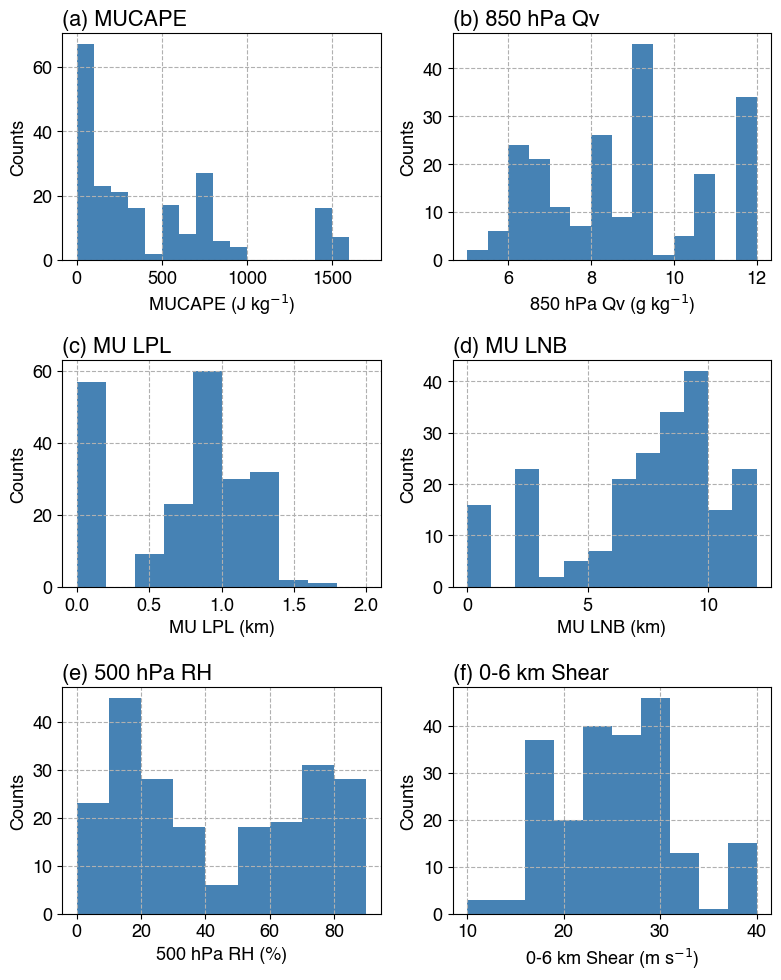

In [79]:
xbins = [[binv_cape, binv_q850p],
         [binv_lpl, binv_lnb],
         [binv_rh500p, binv_shear6mag]]
hist = [[hist_cape, hist_q850p],
        [hist_lpl, hist_lnb],
        [hist_rh500p, hist_shear6mag]]
xlabels = [['MUCAPE (J kg$^{-1}$)', '850 hPa Qv (g kg$^{-1}$)'],
           ['MU LPL (km)', 'MU LNB (km)'],
           ['500 hPa RH (%)', '0-6 km Shear (m s$^{-1}$)']]
titles = [['(a) MUCAPE', '(b) 850 hPa Qv'],
           ['(c) MU LPL', '(d) MU LNB'],
           ['(e) 500 hPa RH', '(f) 0-6 km Shear']]
figname = f'{figdir}CI_eSDC_08LT_environments_pdf.png'
fig = plot_3x2(xbins, hist, xlabels, titles, figname)

In [80]:
figname

'/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/figures/celltrack_environment_stats_jim/CI_eSDC_08LT_environments_pdf.png'